In [20]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE = 255
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [22]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Food Classification Dataset9",
    shuffle=True,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 6316 files belonging to 11 classes.


In [23]:
class_names = dataset.class_names
class_names

['Donut',
 'chapati',
 'cheesecake',
 'dhokla',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kulfi',
 'masala_dosa',
 'paani_puri',
 'samosa']

In [24]:
len(dataset)

198

In [25]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 255, 255, 3)
[ 2  2  2  2  0  2  8  2  5  1  4  5  8  1  0  5  5  8  2  1  0  5  5  0
  5  3 10  5  3  5  5  1]


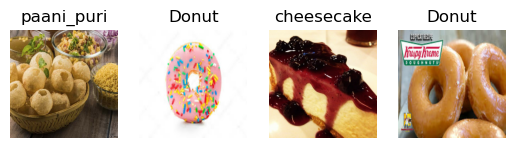

In [26]:
for image_batch,label_batch in dataset.take(1):
    for i in range(4):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

training : 80%
validation : 10%
test : 10%

In [27]:
# dataset.take(n) #pick first n batches. slicing [:n]
# dataset.skip(n) #pick batches after n. skicing [n:]

In [28]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size = len(dataset)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0,255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
train_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 11

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')  
])

model.build(input_shape=input_shape)

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 126, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 64)       

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
158/158 [==============================] - 101s 639ms/step - loss: 0.6529 - accuracy: 0.7804 - val_loss: 1.3496 - val_accuracy: 0.6118
Epoch 2/100
158/158 [==============================] - 93s 585ms/step - loss: 0.6686 - accuracy: 0.7720 - val_loss: 1.4590 - val_accuracy: 0.5625
Epoch 3/100
158/158 [==============================] - 89s 560ms/step - loss: 0.6566 - accuracy: 0.7853 - val_loss: 1.5091 - val_accuracy: 0.5641
Epoch 4/100
158/158 [==============================] - 92s 584ms/step - loss: 0.6345 - accuracy: 0.7893 - val_loss: 1.3527 - val_accuracy: 0.5576
Epoch 5/100
158/158 [==============================] - 91s 574ms/step - loss: 0.6347 - accuracy: 0.7943 - val_loss: 1.5775 - val_accuracy: 0.5674
Epoch 6/100
158/158 [==============================] - 87s 548ms/step - loss: 0.6576 - accuracy: 0.7889 - val_loss: 1.6070 - val_accuracy: 0.5197
Epoch 7/100
158/158 [==============================] - 87s 546ms/step - loss: 0.6335 - accuracy: 0.7933 - val_loss: 1.3321 

Epoch 57/100
158/158 [==============================] - 118s 743ms/step - loss: 0.5278 - accuracy: 0.8223 - val_loss: 1.1718 - val_accuracy: 0.6053
Epoch 58/100
158/158 [==============================] - 115s 728ms/step - loss: 0.5241 - accuracy: 0.8243 - val_loss: 1.1630 - val_accuracy: 0.6201
Epoch 59/100
158/158 [==============================] - 112s 707ms/step - loss: 0.5532 - accuracy: 0.8165 - val_loss: 1.4744 - val_accuracy: 0.5641
Epoch 60/100
158/158 [==============================] - 111s 704ms/step - loss: 0.5461 - accuracy: 0.8227 - val_loss: 1.4247 - val_accuracy: 0.5806
Epoch 61/100
158/158 [==============================] - 105s 660ms/step - loss: 0.5410 - accuracy: 0.8201 - val_loss: 1.4368 - val_accuracy: 0.6151
Epoch 62/100
158/158 [==============================] - 111s 701ms/step - loss: 0.6066 - accuracy: 0.7955 - val_loss: 1.3457 - val_accuracy: 0.6003
Epoch 63/100
158/158 [==============================] - 107s 673ms/step - loss: 0.5762 - accuracy: 0.8038 - val_

In [41]:
scores = model.evaluate(test_ds)

21/21 [==============================] - 3s 164ms/step - loss: 1.2015 - accuracy: 0.6205


In [42]:
scores

[1.201466679573059, 0.6205357313156128]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 158}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:
len(history.history['loss'])

100

In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6528531908988953,
 0.6686214804649353,
 0.6565681099891663,
 0.6344581842422485,
 0.6347034573554993]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

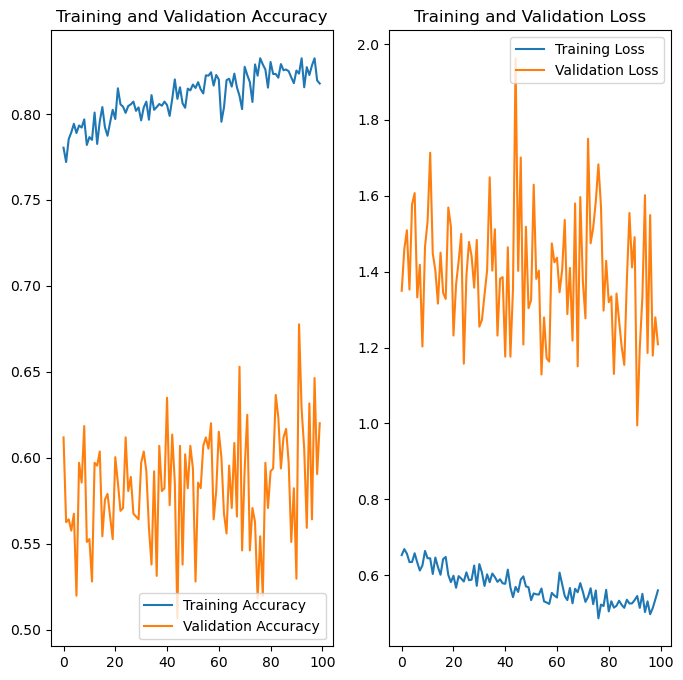

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: kaathi_rolls
1/1 [==============================] - 1s 892ms/step
predicted label: kaathi_rolls


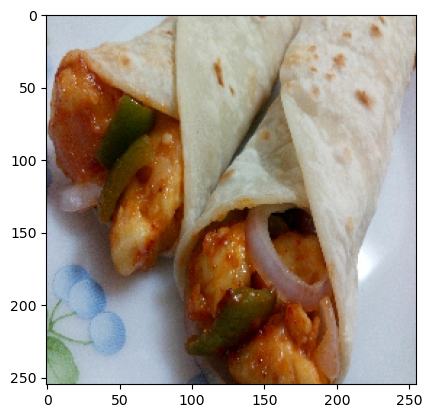

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


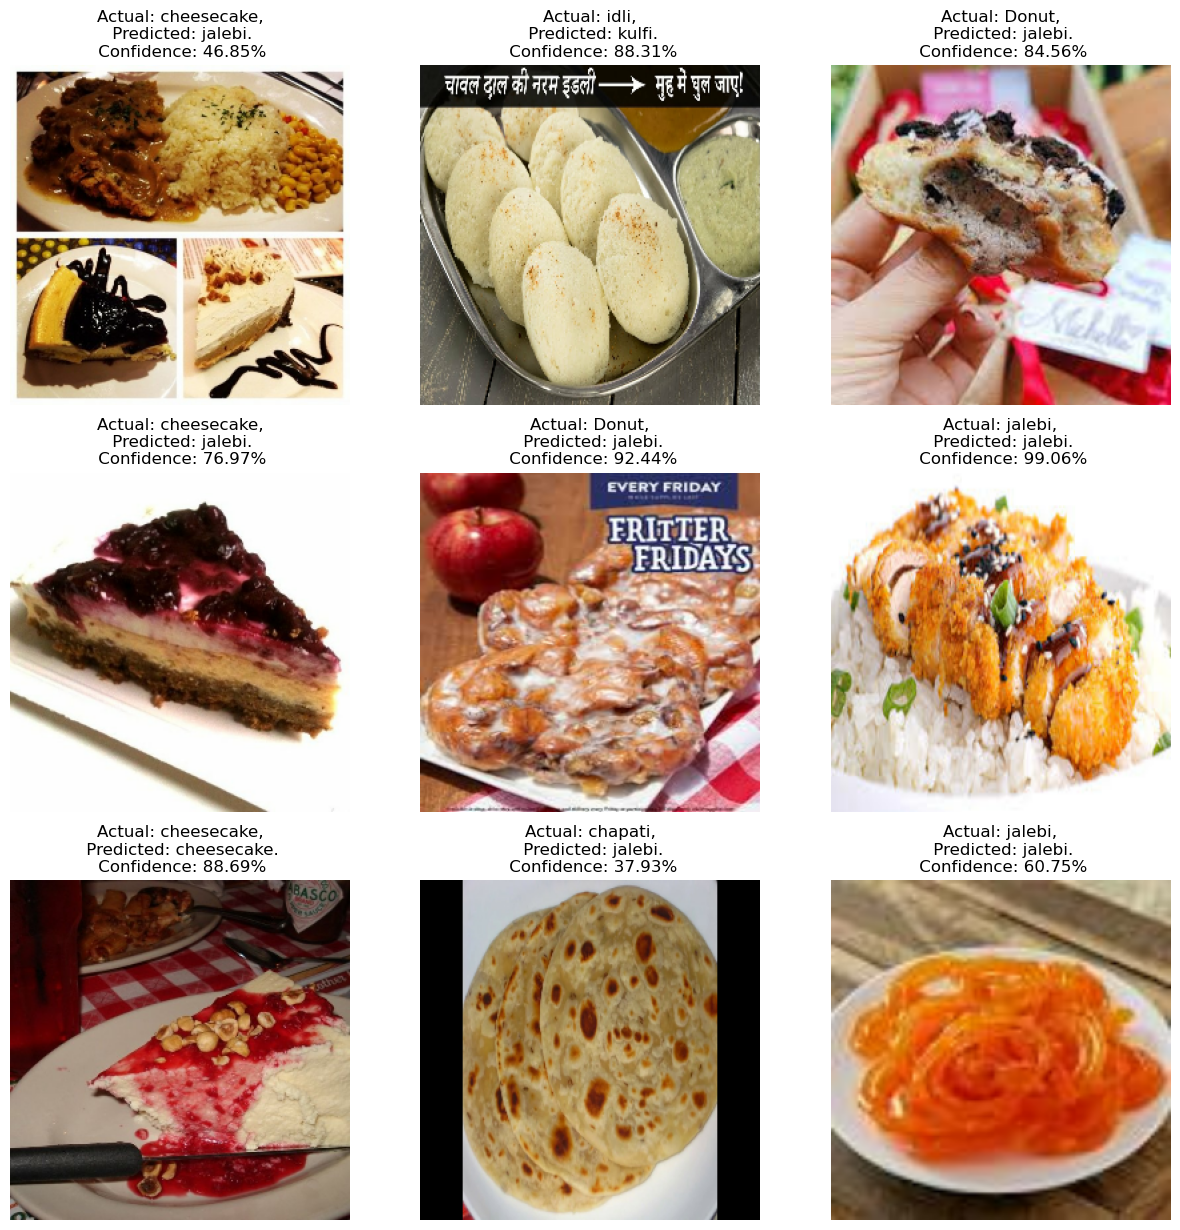

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [59]:
import os
model.save(f"../model/model9")

INFO:tensorflow:Assets written to: ../model/model9\assets


INFO:tensorflow:Assets written to: ../model/model9\assets
